# Behavior discovery

In [ ]:
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

In [ ]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


In [ ]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

In [ ]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

# Get the default device used
device: torch.device = utils.get_device()

Loaded pretrained model gpt2-small into HookedTransformer


## Can GPT-2 small correct misspellings?

In [ ]:
example_prompt = "The correct spelling of the word \"tounge\" is \""
example_answer = "tongue"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' correct', ' spelling', ' of', ' the', ' word', ' "', 't', 'ounge', '"', ' is', ' "']
Tokenized answer: [' tongue']


Performance on answer token:
Rank: 3430     Logit:  5.22 Prob:  0.00% Token: | tongue|

Top 0th token. Logit: 15.42 Prob: 35.00% Token: |t|
Top 1th token. Logit: 12.45 Prob:  1.79% Token: |te|
Top 2th token. Logit: 12.43 Prob:  1.75% Token: |to|
Top 3th token. Logit: 12.41 Prob:  1.72% Token: |T|
Top 4th token. Logit: 12.08 Prob:  1.24% Token: |n|
Top 5th token. Logit: 11.99 Prob:  1.13% Token: |w|
Top 6th token. Logit: 11.65 Prob:  0.80% Token: |p|
Top 7th token. Logit: 11.61 Prob:  0.77% Token: |l|
Top 8th token. Logit: 11.61 Prob:  0.77% Token: |d|
Top 9th token. Logit: 11.53 Prob:  0.72% Token: |s|


Ranks of the answer tokens: [(' tongue', 3430)]

In [ ]:
example_prompt = "The correct spelling of the word \"tounge\" is \"t"
example_answer = "tongue"

utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' correct', ' spelling', ' of', ' the', ' word', ' "', 't', 'ounge', '"', ' is', ' "', 't']
Tokenized answer: [' tongue']


Performance on answer token:
Rank: 7581     Logit:  3.63 Prob:  0.00% Token: | tongue|

Top 0th token. Logit: 16.10 Prob: 17.84% Token: |ounge|
Top 1th token. Logit: 15.61 Prob: 10.93% Token: |ong|
Top 2th token. Logit: 14.11 Prob:  2.44% Token: |ow|
Top 3th token. Logit: 14.08 Prob:  2.36% Token: |oot|
Top 4th token. Logit: 13.68 Prob:  1.58% Token: |ou|
Top 5th token. Logit: 13.62 Prob:  1.50% Token: |uck|
Top 6th token. Logit: 13.44 Prob:  1.25% Token: |oy|
Top 7th token. Logit: 13.44 Prob:  1.24% Token: |ough|
Top 8th token. Logit: 13.33 Prob:  1.12% Token: |ear|
Top 9th token. Logit: 13.17 Prob:  0.96% Token: |urtle|


Ranks of the answer tokens: [(' tongue', 7581)]

This gives us a 10% chance of selecting "ong" vs 18% of selecting "ounge", so still fairly unlikely but not bad. Let's see what happens if we append that:

In [ ]:
example_prompt = "The correct spelling of the word \"tounge\" is \"tong"
example_answer = "ue"

utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' correct', ' spelling', ' of', ' the', ' word', ' "', 't', 'ounge', '"', ' is', ' "', 't', 'ong']
Tokenized answer: [' u', 'e']


Performance on answer token:
Rank: 287      Logit:  8.24 Prob:  0.00% Token: | u|

Top 0th token. Logit: 19.76 Prob: 95.94% Token: |ue|
Top 1th token. Logit: 14.84 Prob:  0.70% Token: |ues|
Top 2th token. Logit: 14.44 Prob:  0.47% Token: |ued|
Top 3th token. Logit: 14.27 Prob:  0.40% Token: |"|
Top 4th token. Logit: 13.02 Prob:  0.11% Token: |le|
Top 5th token. Logit: 13.01 Prob:  0.11% Token: |rel|
Top 6th token. Logit: 12.87 Prob:  0.10% Token: |",|
Top 7th token. Logit: 12.75 Prob:  0.09% Token: |".|
Top 8th token. Logit: 12.66 Prob:  0.08% Token: |er|
Top 9th token. Logit: 12.58 Prob:  0.07% Token: |-|


Performance on answer token:
Rank: 3        Logit: 11.89 Prob:  2.54% Token: |e|

Top 0th token. Logit: 12.62 Prob:  5.30% Token: |k|
Top 1th token. Logit: 12.49 Prob:  4.65% Token: |ke|
Top 2th token. Logit: 12.21 Prob:  3.52% Token: |i|
Top 3th token. Logit: 11.89 Prob:  2.54% Token: |e|
Top 4th token. Logit: 11.55 Prob:  1.80% Token: |w|
Top 5th token. Logit: 11.40 Prob:  1.56% Token: |'|
Top 6th token. Logit: 11.40 Prob:  1.56% Token: |o|
Top 7th token. Logit: 11.30 Prob:  1.42% Token: |"|
Top 8th token. Logit: 11.29 Prob:  1.40% Token: |-|
Top 9th token. Logit: 11.26 Prob:  1.36% Token: |u|


Ranks of the answer tokens: [(' u', 287), ('e', 3)]

The test_prompt tokenizer converts ue into two tokens and I'm not sure atm how to make it take a token literal, but manual inspection shows that "ue" is the number one prediction. However, this is going to be difficult to test naively because the model is outputting multiple tokens that give the correct token when concatenated.

Let's see if we can get the model to produce a single token correction.

In [ ]:
example_prompt = "Mispelling: bda|Correct spelling: bad\nMispelling: godo|Correct spelling:"
example_answer = " good"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Mis', 'pelling', ':', ' b', 'da', '|', 'Correct', ' spelling', ':', ' bad', '\n', 'Mis', 'pelling', ':', ' god', 'o', '|', 'Correct', ' spelling', ':']
Tokenized answer: [' good']


Performance on answer token:
Rank: 1        Logit: 12.77 Prob:  7.09% Token: | good|

Top 0th token. Logit: 14.16 Prob: 28.42% Token: | bad|
Top 1th token. Logit: 12.77 Prob:  7.09% Token: | good|
Top 2th token. Logit: 12.66 Prob:  6.31% Token: | god|
Top 3th token. Logit: 11.93 Prob:  3.04% Token: | b|
Top 4th token. Logit: 11.30 Prob:  1.62% Token: | ok|
Top 5th token. Logit: 10.98 Prob:  1.18% Token: | no|
Top 6th token. Logit: 10.60 Prob:  0.80% Token: | not|
Top 7th token. Logit: 10.54 Prob:  0.76% Token: | evil|
Top 8th token. Logit: 10.36 Prob:  0.63% Token: | m|
Top 9th token. Logit: 10.31 Prob:  0.60% Token: | a|


Ranks of the answer tokens: [(' good', 1)]

This looks like an induction head in action predicting the string after the previous "Correct spelling" instance. However, we do see that "good" is the second predicted token, which is promising. Perhaps a different prompt format is better.

In [ ]:
example_prompt = "The correct spelling of the word \"panst\" is \""
example_answer = " pants"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' correct', ' spelling', ' of', ' the', ' word', ' "', 'pan', 'st', '"', ' is', ' "']
Tokenized answer: [' pants']


Performance on answer token:
Rank: 18483    Logit:  0.29 Prob:  0.00% Token: | pants|

Top 0th token. Logit: 14.83 Prob: 37.36% Token: |pan|
Top 1th token. Logit: 12.70 Prob:  4.42% Token: |p|
Top 2th token. Logit: 11.18 Prob:  0.97% Token: |m|
Top 3th token. Logit: 11.15 Prob:  0.94% Token: |ch|
Top 4th token. Logit: 11.15 Prob:  0.94% Token: |Pan|
Top 5th token. Logit: 10.99 Prob:  0.80% Token: |par|
Top 6th token. Logit: 10.82 Prob:  0.68% Token: |c|
Top 7th token. Logit: 10.74 Prob:  0.63% Token: |pal|
Top 8th token. Logit: 10.66 Prob:  0.58% Token: |n|
Top 9th token. Logit: 10.63 Prob:  0.56% Token: |P|


Ranks of the answer tokens: [(' pants', 18483)]

In [ ]:
example_prompt = "The correct spelling of the word \"panst\" is \"pan"
example_answer = "ts"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' correct', ' spelling', ' of', ' the', ' word', ' "', 'pan', 'st', '"', ' is', ' "', 'pan']
Tokenized answer: [' ts']


Performance on answer token:
Rank: 829      Logit:  5.12 Prob:  0.01% Token: | ts|

Top 0th token. Logit: 13.73 Prob: 45.51% Token: |st|
Top 1th token. Logit: 10.87 Prob:  2.59% Token: |-|
Top 2th token. Logit: 10.68 Prob:  2.16% Token: |"|
Top 3th token. Logit:  9.91 Prob:  0.99% Token: |se|
Top 4th token. Logit:  9.70 Prob:  0.81% Token: | st|
Top 5th token. Logit:  9.69 Prob:  0.80% Token: |ter|
Top 6th token. Logit:  9.62 Prob:  0.75% Token: |ster|
Top 7th token. Logit:  9.61 Prob:  0.74% Token: |th|
Top 8th token. Logit:  9.46 Prob:  0.64% Token: |".|
Top 9th token. Logit:  9.32 Prob:  0.55% Token: |za|


Ranks of the answer tokens: [(' ts', 829)]

This task might also be difficult for the mdoel because of the lack of context in the words around the misspelling. Let's try putting the mispelling in a sentence first.

In [ ]:
example_prompt = "The man put on his panst.\nIn the above sentence, \"panst\" is a misspelling of \""
example_answer = "pants"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' man', ' put', ' on', ' his', ' pan', 'st', '.', '\n', 'In', ' the', ' above', ' sentence', ',', ' "', 'pan', 'st', '"', ' is', ' a', ' miss', 'pelling', ' of', ' "']
Tokenized answer: [' pants']


Performance on answer token:
Rank: 14143    Logit:  1.19 Prob:  0.00% Token: | pants|

Top 0th token. Logit: 14.99 Prob: 23.88% Token: |pan|
Top 1th token. Logit: 13.18 Prob:  3.91% Token: |p|
Top 2th token. Logit: 11.97 Prob:  1.16% Token: |man|
Top 3th token. Logit: 11.77 Prob:  0.95% Token: |par|
Top 4th token. Logit: 11.70 Prob:  0.88% Token: |pal|
Top 5th token. Logit: 11.50 Prob:  0.72% Token: |f|
Top 6th token. Logit: 11.50 Prob:  0.72% Token: |m|
Top 7th token. Logit: 11.48 Prob:  0.71% Token: |to|
Top 8th token. Logit: 11.43 Prob:  0.68% Token: |st|
Top 9th token. Logit: 11.42 Prob:  0.67% Token: |pot|


Ranks of the answer tokens: [(' pants', 14143)]

## Misspelling takeaways

The model doesn't naturally want to predict single-token misspelling corrections so it's going to be difficult to get meaningful results quickly. If I were to continue searching down this path, I would need to:
* reliably get the model to predict the correct spelling, either by better prompting or using a larger model
* handle the correct result being split up into multiple tokens

# Gender pronoun info

In [ ]:
example_prompt = "The man and the woman went to bed because she was tired. Who does 'she' refer to in this sentence? The"
example_answer = " woman"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'The', ' man', ' and', ' the', ' woman', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' Who', ' does', " '", 'she', "'", ' refer', ' to', ' in', ' this', ' sentence', '?', ' The']
Tokenized answer: [' woman']


Performance on answer token:
Rank: 0        Logit: 14.15 Prob: 22.47% Token: | woman|

Top 0th token. Logit: 14.15 Prob: 22.47% Token: | woman|
Top 1th token. Logit: 14.12 Prob: 21.80% Token: | man|
Top 2th token. Logit: 11.60 Prob:  1.75% Token: | person|
Top 3th token. Logit: 11.32 Prob:  1.33% Token: | first|
Top 4th token. Logit: 11.16 Prob:  1.13% Token: | one|
Top 5th token. Logit: 10.87 Prob:  0.84% Token: | girl|
Top 6th token. Logit: 10.81 Prob:  0.79% Token: | question|
Top 7th token. Logit: 10.77 Prob:  0.76% Token: | answer|
Top 8th token. Logit: 10.71 Prob:  0.72% Token: | victim|
Top 9th token. Logit: 10.68 Prob:  0.70% Token: | word|


Ranks of the answer tokens: [(' woman', 0)]

In [ ]:
example_prompt = "Yesterday, Matt and Jill went to bed because she was tired. The tired person's name was"
example_answer = " Jill"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' Matt', ' and', ' Jill', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' The', ' tired', ' person', "'s", ' name', ' was']
Tokenized answer: [' Jill']


Performance on answer token:
Rank: 1        Logit: 12.30 Prob:  2.15% Token: | Jill|

Top 0th token. Logit: 14.08 Prob: 12.65% Token: | Matt|
Top 1th token. Logit: 12.30 Prob:  2.15% Token: | Jill|
Top 2th token. Logit: 11.92 Prob:  1.47% Token: | "|
Top 3th token. Logit: 11.70 Prob:  1.18% Token: | Amanda|
Top 4th token. Logit: 11.54 Prob:  1.01% Token: | Ann|
Top 5th token. Logit: 11.47 Prob:  0.93% Token: | Sarah|
Top 6th token. Logit: 11.19 Prob:  0.71% Token: | John|
Top 7th token. Logit: 11.09 Prob:  0.64% Token: | Megan|
Top 8th token. Logit: 11.05 Prob:  0.61% Token: | Kate|
Top 9th token. Logit: 11.03 Prob:  0.60% Token: | Joe|


Ranks of the answer tokens: [(' Jill', 1)]

Let's set up the experiment the same way as the IOI experiment

In [ ]:
prompt_format = [
    "Yesterday, the {} and the {} went to bed because {} was tired. Who was tired? The",
#    "The {} and the {} ate some food because {} was hungry. Who does '{}' refer to in this sentence? The",
#    "The {} and the {} played a game because {} was bored. Who does '{}' refer to in this sentence? The",
]
descriptors = [
    (("she", "he"), ("woman", "man")),
    (("she", "he"), ("girl", "boy")),
#    (("she", "he"), ("wife", "husband")),
]
# List of prompts
prompts = []
# List of answers, in the format (correct, incorrect)
answers = []
# List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
answer_tokens = []

# combinatorial for more data
for i in range(len(prompt_format)):
    for j in range(len(descriptors)):
        for k in range(2):
            for l in range(2):
                answers.append((descriptors[j][1][k], descriptors[j][1][1 - k]))
                # correct, incorrect
                answer_tokens.append((model.to_single_token(answers[-1][1][k]), model.to_single_token(answers[-1][1][1 - k])))

                # Try both orders to add more examples
                first_word = descriptors[j][1][l]
                second_word = descriptors[j][1][1 - l]

                # third word is the correct answer, making the model predict the correct match
                third_word = descriptors[j][0][k]
                prompts.append(prompt_format[i].format(first_word, second_word, third_word))
answer_tokens = torch.tensor(answer_tokens).to(device)
#print(prompts)
#print(answers)
print(list(zip(prompts, answers)))

[('Yesterday, the woman and the man went to bed because she was tired. Who was tired? The', ('woman', 'man')), ('Yesterday, the man and the woman went to bed because she was tired. Who was tired? The', ('woman', 'man')), ('Yesterday, the woman and the man went to bed because he was tired. Who was tired? The', ('man', 'woman')), ('Yesterday, the man and the woman went to bed because he was tired. Who was tired? The', ('man', 'woman')), ('Yesterday, the girl and the boy went to bed because she was tired. Who was tired? The', ('girl', 'boy')), ('Yesterday, the boy and the girl went to bed because she was tired. Who was tired? The', ('girl', 'boy')), ('Yesterday, the girl and the boy went to bed because he was tired. Who was tired? The', ('boy', 'girl')), ('Yesterday, the boy and the girl went to bed because he was tired. Who was tired? The', ('boy', 'girl'))]


In [ ]:
for prompt in prompts:
    str_tokens = model.to_str_tokens(prompt)
    print("Prompt length:", len(str_tokens))
    print("Prompt as tokens:", str_tokens)

Prompt length: 21
Prompt as tokens: ['<|endoftext|>', 'Yesterday', ',', ' the', ' woman', ' and', ' the', ' man', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Prompt length: 21
Prompt as tokens: ['<|endoftext|>', 'Yesterday', ',', ' the', ' man', ' and', ' the', ' woman', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Prompt length: 21
Prompt as tokens: ['<|endoftext|>', 'Yesterday', ',', ' the', ' woman', ' and', ' the', ' man', ' went', ' to', ' bed', ' because', ' he', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Prompt length: 21
Prompt as tokens: ['<|endoftext|>', 'Yesterday', ',', ' the', ' man', ' and', ' the', ' woman', ' went', ' to', ' bed', ' because', ' he', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Prompt length: 21
Prompt as tokens: ['<|endoftext|>', 'Yesterday', ',', ' the', ' girl', ' and', ' the', ' boy', ' went', 

In [ ]:
tokens = model.to_tokens(prompts, prepend_bos=True)

# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

In [ ]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()


print(
    "Per prompt logit difference:",
    logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(logits_to_ave_logit_diff(original_logits, answer_tokens).item(), 3),
)

Per prompt logit difference: tensor([-1.5550, -1.4760,  1.5880,  1.5300, -2.8360, -3.1370,  1.6940,  1.5530])
Average logit difference: -0.33


In [ ]:
import math
math.exp(-.442)

0.6427496354555312

It looks like the model is only slightly more confident about the correct vs incorrect answers here. Let's check the predictions a bit more closely here.

In [ ]:
for i in range(len(prompts)):
    utils.test_prompt(prompts[i], answers[i][0], model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' woman', ' and', ' the', ' man', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' woman']


Performance on answer token:
Rank: 1        Logit: 14.65 Prob: 22.62% Token: | woman|

Top 0th token. Logit: 14.68 Prob: 23.29% Token: | man|
Top 1th token. Logit: 14.65 Prob: 22.62% Token: | woman|
Top 2th token. Logit: 12.34 Prob:  2.25% Token: | two|
Top 3th token. Logit: 12.30 Prob:  2.16% Token: | police|
Top 4th token. Logit: 11.56 Prob:  1.02% Token: | guy|
Top 5th token. Logit: 11.51 Prob:  0.98% Token: | person|
Top 6th token. Logit: 11.51 Prob:  0.97% Token: | answer|
Top 7th token. Logit: 11.45 Prob:  0.92% Token: | women|
Top 8th token. Logit: 11.43 Prob:  0.90% Token: | girl|
Top 9th token. Logit: 11.41 Prob:  0.88% Token: | doctor|


Ranks of the answer tokens: [(' woman', 1)]

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' man', ' and', ' the', ' woman', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' woman']


Performance on answer token:
Rank: 1        Logit: 14.52 Prob: 21.42% Token: | woman|

Top 0th token. Logit: 14.63 Prob: 23.85% Token: | man|
Top 1th token. Logit: 14.52 Prob: 21.42% Token: | woman|
Top 2th token. Logit: 12.16 Prob:  2.02% Token: | police|
Top 3th token. Logit: 11.90 Prob:  1.56% Token: | two|
Top 4th token. Logit: 11.76 Prob:  1.36% Token: | answer|
Top 5th token. Logit: 11.54 Prob:  1.09% Token: | guy|
Top 6th token. Logit: 11.36 Prob:  0.91% Token: | girl|
Top 7th token. Logit: 11.33 Prob:  0.88% Token: | person|
Top 8th token. Logit: 11.32 Prob:  0.87% Token: | women|
Top 9th token. Logit: 11.22 Prob:  0.79% Token: | doctor|


Ranks of the answer tokens: [(' woman', 1)]

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' woman', ' and', ' the', ' man', ' went', ' to', ' bed', ' because', ' he', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' man']


Performance on answer token:
Rank: 0        Logit: 14.74 Prob: 24.87% Token: | man|

Top 0th token. Logit: 14.74 Prob: 24.87% Token: | man|
Top 1th token. Logit: 14.67 Prob: 23.05% Token: | woman|
Top 2th token. Logit: 12.22 Prob:  2.00% Token: | police|
Top 3th token. Logit: 12.17 Prob:  1.89% Token: | two|
Top 4th token. Logit: 11.62 Prob:  1.10% Token: | guy|
Top 5th token. Logit: 11.49 Prob:  0.96% Token: | person|
Top 6th token. Logit: 11.44 Prob:  0.92% Token: | answer|
Top 7th token. Logit: 11.42 Prob:  0.89% Token: | girl|
Top 8th token. Logit: 11.42 Prob:  0.89% Token: | doctor|
Top 9th token. Logit: 11.39 Prob:  0.87% Token: | women|


Ranks of the answer tokens: [(' man', 0)]

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' man', ' and', ' the', ' woman', ' went', ' to', ' bed', ' because', ' he', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' man']


Performance on answer token:
Rank: 0        Logit: 14.53 Prob: 23.23% Token: | man|

Top 0th token. Logit: 14.53 Prob: 23.23% Token: | man|
Top 1th token. Logit: 14.40 Prob: 20.36% Token: | woman|
Top 2th token. Logit: 12.13 Prob:  2.11% Token: | police|
Top 3th token. Logit: 11.82 Prob:  1.53% Token: | two|
Top 4th token. Logit: 11.63 Prob:  1.28% Token: | answer|
Top 5th token. Logit: 11.49 Prob:  1.11% Token: | guy|
Top 6th token. Logit: 11.42 Prob:  1.03% Token: | women|
Top 7th token. Logit: 11.37 Prob:  0.98% Token: | person|
Top 8th token. Logit: 11.18 Prob:  0.81% Token: | girl|
Top 9th token. Logit: 11.16 Prob:  0.80% Token: | first|


Ranks of the answer tokens: [(' man', 0)]

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' girl', ' and', ' the', ' boy', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' girl']


Performance on answer token:
Rank: 0        Logit: 15.21 Prob: 34.42% Token: | girl|

Top 0th token. Logit: 15.21 Prob: 34.42% Token: | girl|
Top 1th token. Logit: 14.16 Prob: 12.00% Token: | boy|
Top 2th token. Logit: 12.53 Prob:  2.37% Token: | girls|
Top 3th token. Logit: 12.36 Prob:  1.98% Token: | two|
Top 4th token. Logit: 12.16 Prob:  1.63% Token: | man|
Top 5th token. Logit: 11.93 Prob:  1.30% Token: | boys|
Top 6th token. Logit: 11.86 Prob:  1.21% Token: | police|
Top 7th token. Logit: 11.71 Prob:  1.04% Token: | answer|
Top 8th token. Logit: 11.67 Prob:  1.00% Token: | other|
Top 9th token. Logit: 11.49 Prob:  0.83% Token: | child|


Ranks of the answer tokens: [(' girl', 0)]

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' boy', ' and', ' the', ' girl', ' went', ' to', ' bed', ' because', ' she', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' girl']


Performance on answer token:
Rank: 0        Logit: 14.60 Prob: 21.93% Token: | girl|

Top 0th token. Logit: 14.60 Prob: 21.93% Token: | girl|
Top 1th token. Logit: 14.47 Prob: 19.31% Token: | boy|
Top 2th token. Logit: 12.24 Prob:  2.07% Token: | boys|
Top 3th token. Logit: 12.17 Prob:  1.93% Token: | two|
Top 4th token. Logit: 12.13 Prob:  1.85% Token: | girls|
Top 5th token. Logit: 11.88 Prob:  1.45% Token: | man|
Top 6th token. Logit: 11.75 Prob:  1.27% Token: | police|
Top 7th token. Logit: 11.70 Prob:  1.20% Token: | child|
Top 8th token. Logit: 11.68 Prob:  1.18% Token: | answer|
Top 9th token. Logit: 11.45 Prob:  0.94% Token: | parents|


Ranks of the answer tokens: [(' girl', 0)]

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' girl', ' and', ' the', ' boy', ' went', ' to', ' bed', ' because', ' he', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' boy']


Performance on answer token:
Rank: 1        Logit: 14.29 Prob: 14.05% Token: | boy|

Top 0th token. Logit: 15.19 Prob: 34.57% Token: | girl|
Top 1th token. Logit: 14.29 Prob: 14.05% Token: | boy|
Top 2th token. Logit: 12.33 Prob:  1.98% Token: | girls|
Top 3th token. Logit: 12.20 Prob:  1.75% Token: | man|
Top 4th token. Logit: 12.15 Prob:  1.66% Token: | two|
Top 5th token. Logit: 11.80 Prob:  1.16% Token: | boys|
Top 6th token. Logit: 11.75 Prob:  1.11% Token: | police|
Top 7th token. Logit: 11.61 Prob:  0.97% Token: | other|
Top 8th token. Logit: 11.59 Prob:  0.95% Token: | answer|
Top 9th token. Logit: 11.48 Prob:  0.85% Token: | child|


Ranks of the answer tokens: [(' boy', 1)]

Tokenized prompt: ['<|endoftext|>', 'Yesterday', ',', ' the', ' boy', ' and', ' the', ' girl', ' went', ' to', ' bed', ' because', ' he', ' was', ' tired', '.', ' Who', ' was', ' tired', '?', ' The']
Tokenized answer: [' boy']


Performance on answer token:
Rank: 0        Logit: 14.43 Prob: 19.85% Token: | boy|

Top 0th token. Logit: 14.43 Prob: 19.85% Token: | boy|
Top 1th token. Logit: 14.40 Prob: 19.36% Token: | girl|
Top 2th token. Logit: 12.21 Prob:  2.17% Token: | boys|
Top 3th token. Logit: 12.07 Prob:  1.89% Token: | girls|
Top 4th token. Logit: 12.02 Prob:  1.79% Token: | two|
Top 5th token. Logit: 11.86 Prob:  1.53% Token: | man|
Top 6th token. Logit: 11.80 Prob:  1.43% Token: | police|
Top 7th token. Logit: 11.65 Prob:  1.24% Token: | child|
Top 8th token. Logit: 11.53 Prob:  1.10% Token: | answer|
Top 9th token. Logit: 11.51 Prob:  1.07% Token: | parents|


Ranks of the answer tokens: [(' boy', 0)]

I don't think the model can quite do this, unfortunately.

# Translation

In [ ]:
example_prompt = "English: man|French:"
example_answer = " homme"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'English', ':', ' man', '|', 'French', ':']
Tokenized answer: [' hom', 'me']


Performance on answer token:
Rank: 281      Logit:  6.13 Prob:  0.04% Token: | hom|

Top 0th token. Logit: 12.67 Prob: 26.06% Token: | man|
Top 1th token. Logit: 10.01 Prob:  1.83% Token: | woman|
Top 2th token. Logit:  9.90 Prob:  1.64% Token: | m|
Top 3th token. Logit:  9.39 Prob:  0.98% Token: | n|
Top 4th token. Logit:  9.23 Prob:  0.84% Token: | d|
Top 5th token. Logit:  9.19 Prob:  0.81% Token: | c|
Top 6th token. Logit:  9.17 Prob:  0.79% Token: | l|
Top 7th token. Logit:  9.13 Prob:  0.76% Token: | f|
Top 8th token. Logit:  8.90 Prob:  0.60% Token: | b|
Top 9th token. Logit:  8.79 Prob:  0.54% Token: | j|


Performance on answer token:
Rank: 3        Logit: 13.77 Prob:  3.69% Token: |me|

Top 0th token. Logit: 16.13 Prob: 39.05% Token: |o|
Top 1th token. Logit: 14.23 Prob:  5.80% Token: |ie|
Top 2th token. Logit: 13.94 Prob:  4.36% Token: |ero|
Top 3th token. Logit: 13.77 Prob:  3.69% Token: |me|
Top 4th token. Logit: 13.19 Prob:  2.05% Token: |é|
Top 5th token. Logit: 13.12 Prob:  1.92% Token: |in|
Top 6th token. Logit: 12.99 Prob:  1.68% Token: |un|
Top 7th token. Logit: 12.92 Prob:  1.58% Token: |ophone|
Top 8th token. Logit: 12.82 Prob:  1.43% Token: |i|
Top 9th token. Logit: 12.71 Prob:  1.28% Token: |os|


Ranks of the answer tokens: [(' hom', 281), ('me', 3)]

# Surname

In [ ]:
example_prompt = "Mark Johnson usually goes by Mr."
example_answer = " Johnson"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Mark', ' Johnson', ' usually', ' goes', ' by', ' Mr', '.']
Tokenized answer: [' Johnson']


Performance on answer token:
Rank: 0        Logit: 14.25 Prob: 19.35% Token: | Johnson|

Top 0th token. Logit: 14.25 Prob: 19.35% Token: | Johnson|
Top 1th token. Logit: 11.02 Prob:  0.76% Token: | T|
Top 2th token. Logit: 11.01 Prob:  0.75% Token: | M|
Top 3th token. Logit: 10.96 Prob:  0.72% Token: | Smith|
Top 4th token. Logit: 10.96 Prob:  0.72% Token: | Jones|
Top 5th token. Logit: 10.80 Prob:  0.61% Token: | B|
Top 6th token. Logit: 10.80 Prob:  0.61% Token: | J|
Top 7th token. Logit: 10.68 Prob:  0.54% Token: | G|
Top 8th token. Logit: 10.68 Prob:  0.54% Token: | Mark|
Top 9th token. Logit: 10.61 Prob:  0.50% Token: | P|


Ranks of the answer tokens: [(' Johnson', 0)]

In [ ]:
example_prompt = "Johnson Mark usually goes by Mr."
example_answer = " Affleck"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Johnson', ' Mark', ' usually', ' goes', ' by', ' Mr', '.']
Tokenized answer: [' Aff', 'leck']


Performance on answer token:
Rank: 2947     Logit:  5.56 Prob:  0.00% Token: | Aff|

Top 0th token. Logit: 14.36 Prob: 27.36% Token: | Mark|
Top 1th token. Logit: 11.84 Prob:  2.20% Token: | Johnson|
Top 2th token. Logit: 10.90 Prob:  0.86% Token: | M|
Top 3th token. Logit: 10.64 Prob:  0.67% Token: | J|
Top 4th token. Logit: 10.54 Prob:  0.60% Token: | Jack|
Top 5th token. Logit: 10.49 Prob:  0.57% Token: | R|
Top 6th token. Logit: 10.47 Prob:  0.56% Token: | T|
Top 7th token. Logit: 10.40 Prob:  0.52% Token: | K|
Top 8th token. Logit: 10.24 Prob:  0.45% Token: | L|
Top 9th token. Logit: 10.15 Prob:  0.40% Token: | and|


Performance on answer token:
Rank: 0        Logit: 18.34 Prob: 64.94% Token: |leck|

Top 0th token. Logit: 18.34 Prob: 64.94% Token: |leck|
Top 1th token. Logit: 15.95 Prob:  5.92% Token: |air|
Top 2th token. Logit: 14.38 Prob:  1.24% Token: |liction|
Top 3th token. Logit: 14.26 Prob:  1.10% Token: |ord|
Top 4th token. Logit: 14.19 Prob:  1.02% Token: |l|
Top 5th token. Logit: 14.16 Prob:  0.99% Token: |irm|
Top 6th token. Logit: 14.13 Prob:  0.96% Token: |in|
Top 7th token. Logit: 14.03 Prob:  0.87% Token: |el|
Top 8th token. Logit: 13.50 Prob:  0.51% Token: |e|
Top 9th token. Logit: 13.45 Prob:  0.49% Token: |y|


Ranks of the answer tokens: [(' Aff', 2947), ('leck', 0)]

In [ ]:
prompt_format = [
    "{} {} usually goes by Mr.",
    "{} {} usually goes by Ms.",
    "{} {} usually goes by Mrs.",
]
names = [
    ("Mark", "Grant"),
    ("Paul", "Allen"),
    ("John", "Larry"),
    ("James", "Andy"),
    ("Elizabeth", "Taylor"),
    ("Emily", "Anne"),
    ("Grey", "Ann"),
]
# List of prompts
prompts = []
# List of answers, in the format (correct, incorrect)
answers = []
# List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
answer_tokens = []

# combinatorial for more data
for i in range(len(prompt_format)):
    for j in range(len(names)):
        for k in range(2):
            # correct, incorrect
            answers.append((names[j][k], names[j][1-k]))
            answer_tokens.append((model.to_single_token(answers[-1][0]), model.to_single_token(answers[-1][1])))
            prompts.append(prompt_format[i].format(names[j][1-k], names[j][k]))
answer_tokens = torch.tensor(answer_tokens).to(device)
#print(prompts)
#print(answers)
print(list(zip(prompts, answers)))

[('Grant Mark usually goes by Mr.', ('Mark', 'Grant')), ('Mark Grant usually goes by Mr.', ('Grant', 'Mark')), ('Allen Paul usually goes by Mr.', ('Paul', 'Allen')), ('Paul Allen usually goes by Mr.', ('Allen', 'Paul')), ('Larry John usually goes by Mr.', ('John', 'Larry')), ('John Larry usually goes by Mr.', ('Larry', 'John')), ('Andy James usually goes by Mr.', ('James', 'Andy')), ('James Andy usually goes by Mr.', ('Andy', 'James')), ('Taylor Elizabeth usually goes by Mr.', ('Elizabeth', 'Taylor')), ('Elizabeth Taylor usually goes by Mr.', ('Taylor', 'Elizabeth')), ('Anne Emily usually goes by Mr.', ('Emily', 'Anne')), ('Emily Anne usually goes by Mr.', ('Anne', 'Emily')), ('Ann Grey usually goes by Mr.', ('Grey', 'Ann')), ('Grey Ann usually goes by Mr.', ('Ann', 'Grey')), ('Grant Mark usually goes by Ms.', ('Mark', 'Grant')), ('Mark Grant usually goes by Ms.', ('Grant', 'Mark')), ('Allen Paul usually goes by Ms.', ('Paul', 'Allen')), ('Paul Allen usually goes by Ms.', ('Allen', 'Pa

In [ ]:
for prompt in prompts:
    str_tokens = model.to_str_tokens(prompt)
    print("Prompt length:", len(str_tokens))
    print("Prompt as tokens:", str_tokens)

Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'Grant', ' Mark', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'Mark', ' Grant', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'Allen', ' Paul', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'Paul', ' Allen', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'Larry', ' John', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'John', ' Larry', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'Andy', ' James', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'James', ' Andy', ' usually', ' goes', ' by', ' Mr', '.']
Prompt length: 8
Prompt as tokens: ['<|endoftext|>', 'Taylor', ' Elizabeth', ' usually', ' goes', ' by', ' Mr', 

In [ ]:
tokens = model.to_tokens(prompts, prepend_bos=True)

# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

In [ ]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()


print(
    "Per prompt logit difference:",
    logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(logits_to_ave_logit_diff(original_logits, answer_tokens).item(), 3),
)

Per prompt logit difference: tensor([ 2.8600e+00,  2.9230e+00,  2.0090e+00,  2.5550e+00,  2.1650e+00,
         2.2960e+00,  3.5510e+00,  1.6050e+00, -1.8040e+00,  4.5650e+00,
         4.5400e-01, -4.8700e-01,  5.5100e+00, -2.1820e+00,  3.6680e+00,
         3.0670e+00,  1.5980e+00,  3.8610e+00,  3.1100e+00,  7.6700e-01,
         3.2810e+00,  1.2310e+00,  3.4000e-02,  4.9380e+00,  1.0160e+00,
         4.9000e-01,  4.3930e+00,  6.6600e-01,  3.6230e+00,  3.7980e+00,
         8.2800e-01,  4.2690e+00,  3.8840e+00,  1.0240e+00,  4.0370e+00,
         5.8900e-01, -1.6000e-02,  4.1270e+00, -1.0000e-03,  5.4400e-01,
         4.2260e+00, -1.0000e-01])
Average logit difference: 2.118


In [ ]:
import math
math.exp(2.118)

8.31449186388466

\>8x more likely!

In [ ]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([42, 2, 768])
Logit difference directions shape: torch.Size([42, 768])


In [ ]:
def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=-1
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions,
    ) / len(prompts)

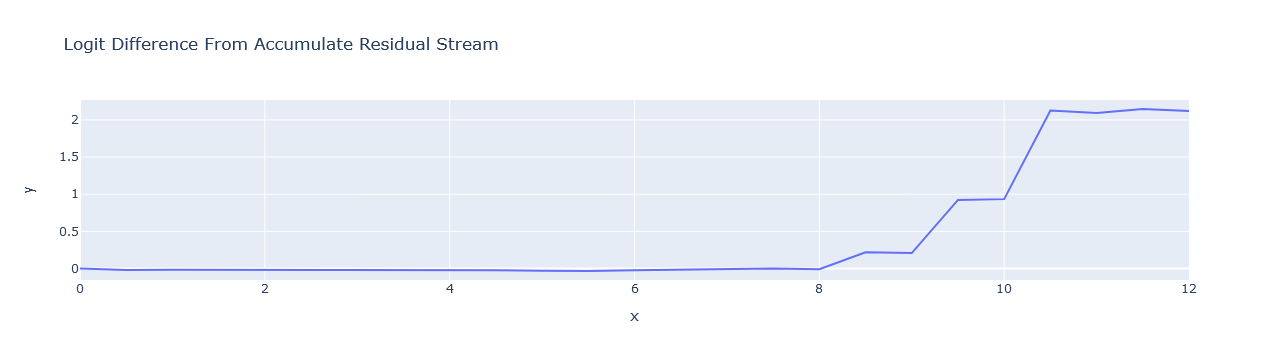

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)
line(
    logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    title="Logit Difference From Accumulate Residual Stream",
)

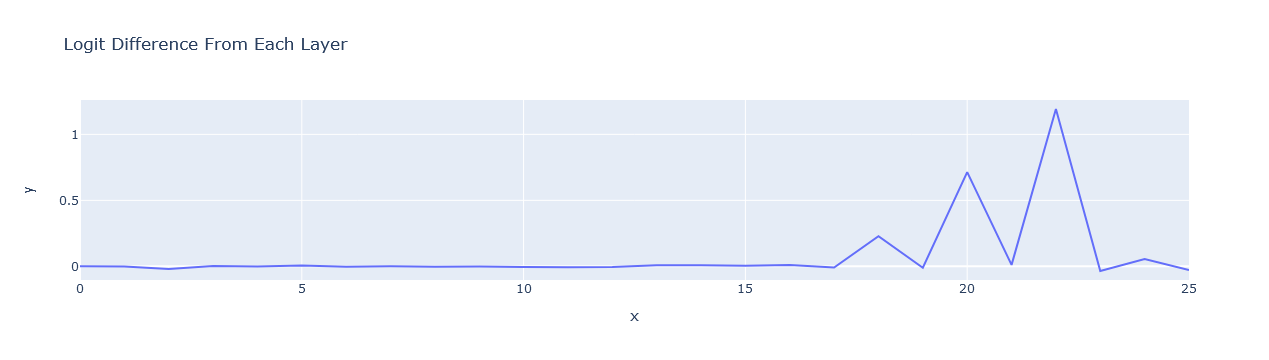

In [ ]:
per_layer_residual, labels = cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

Tried to stack head results when they weren't cached. Computing head results now


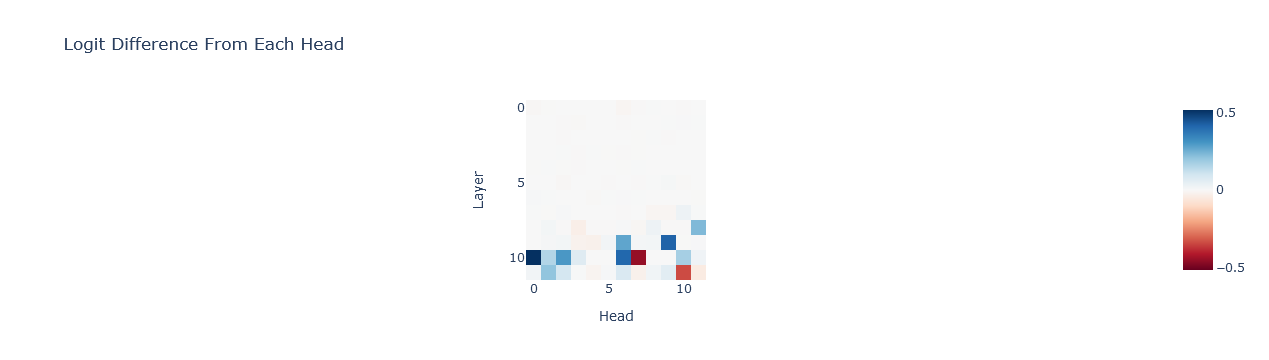

In [ ]:
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

In [ ]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

In [ ]:
top_k = 3

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    cache,
    tokens[0],
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    cache,
    tokens[0],
    title=f"Top {top_k} Negative Logit Attribution Heads",
)

HTML(positive_html + negative_html)

To me, this looks like the same behavior we are seeing in the IOI paper with a name mover and a negative name mover. The question I want to investigate is how the model knows to grab the surname when it sees "Mr.", "Mrs.", etc. instead of grabbing the first name.

The tutorial does the next step of Activation Patching by corrupting the inputs, specifically by swapping the Subject and Indirect Object in either the final phrase or the original phrase. I am not able to swap in the final phase, but I can swap the first name and last name in my example instead because at the end of the day I'm trying to figure out how it knows which name to choose.

In [ ]:
corrupted_prompts = []
for i in range(0, len(prompts), 2):
    corrupted_prompts.append(prompts[i + 1])
    corrupted_prompts.append(prompts[i])
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(
    corrupted_tokens, return_type="logits"
)
corrupted_average_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(original_average_logit_diff.item(), 2))

Corrupted Average Logit Diff -2.12
Clean Average Logit Diff 2.12


In [ ]:
prompts[:4], corrupted_prompts[:4]

(['Grant Mark usually goes by Mr.',
  'Mark Grant usually goes by Mr.',
  'Allen Paul usually goes by Mr.',
  'Paul Allen usually goes by Mr.'],
 ['Mark Grant usually goes by Mr.',
  'Grant Mark usually goes by Mr.',
  'Paul Allen usually goes by Mr.',
  'Allen Paul usually goes by Mr.'])

In [ ]:
model.to_string(corrupted_tokens)

['<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith goes by Mr.',
 '<|endoftext|>Mark Grant Keith go

In [ ]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff) / (
        original_average_logit_diff - corrupted_average_logit_diff
    )


patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
            patched_logit_diff
        )

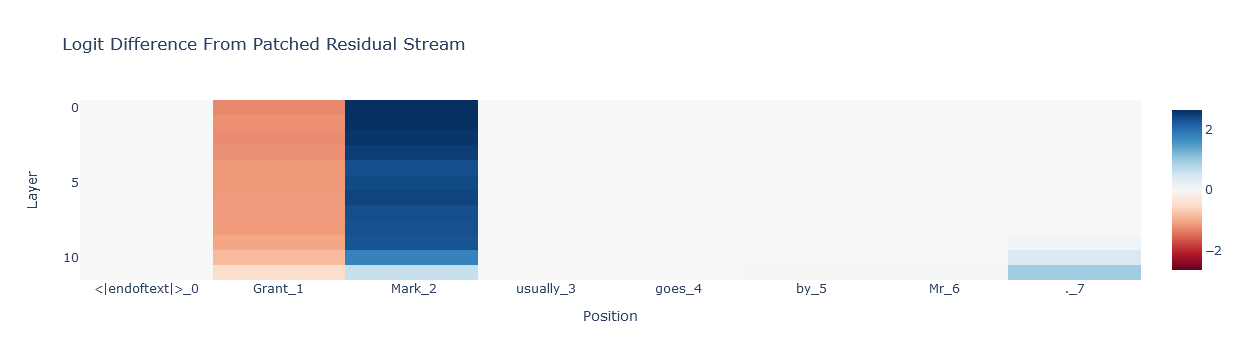

In [ ]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

This differs from the tutorial I'm basing this off in that it seems a lot of *negative* computation is being done on the first name and positive computation on the surname, with all of that being transferred to the final character in the sentence in the 10th layer or so.

In [ ]:
patched_attn_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(
            patched_attn_logits, answer_tokens
        )
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_mlp_logit_diff = logits_to_ave_logit_diff(
            patched_mlp_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(
            patched_attn_logit_diff
        )
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(
            patched_mlp_logit_diff
        )

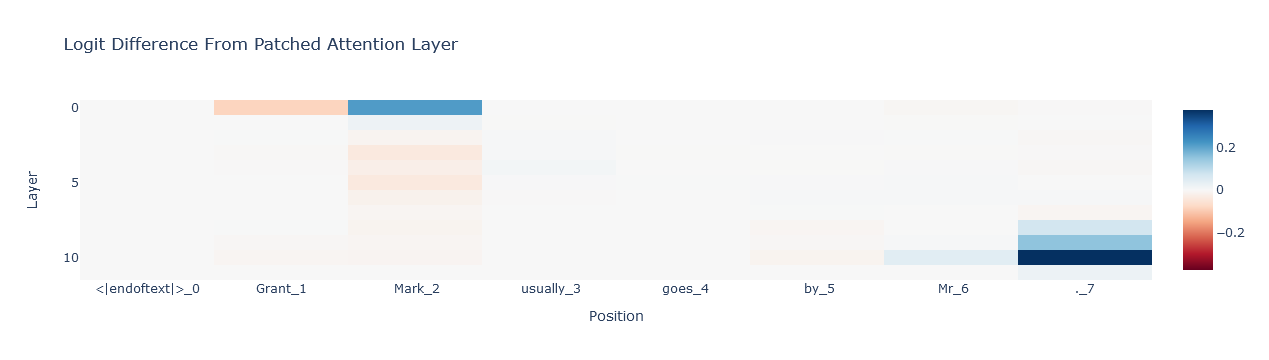

In [ ]:
imshow(
    patched_attn_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention Layer",
    labels={"x": "Position", "y": "Layer"},
)

This is somewhat less localized than the IOI circuit but not extensively so. It seems that most of the computation is actually being done in the first layer attention heads and by the final layers on the last token, which is really interesting. Maybe there is some sort of name connector implemented early on in the network? Alternatively, perhaps the task is simple enough that the entire computation can be done by the final layers.

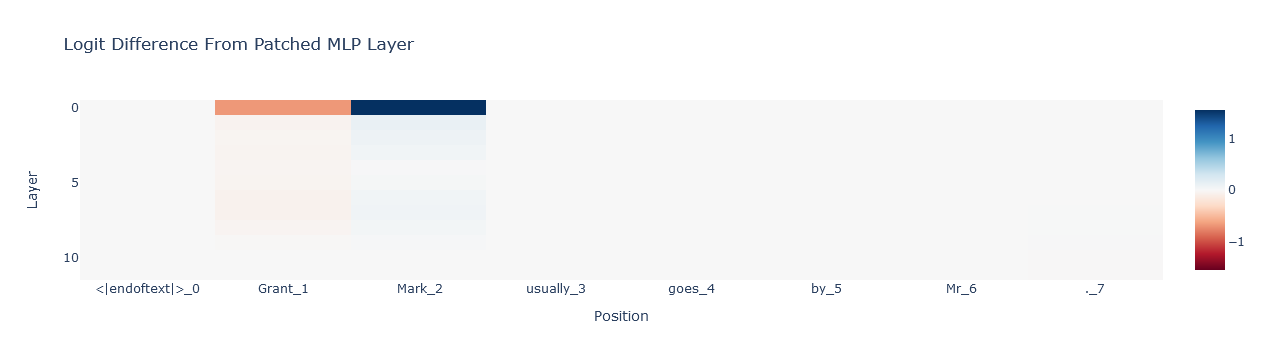

In [ ]:
imshow(
    patched_mlp_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched MLP Layer",
    labels={"x": "Position", "y": "Layer"},
)

We see the same results with the MLP0 layer as in the original tutorial. This could also be a red herring (as described by Neel) but it could also be actually doing computation considering that the same attention layers are similarly active.

In [ ]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

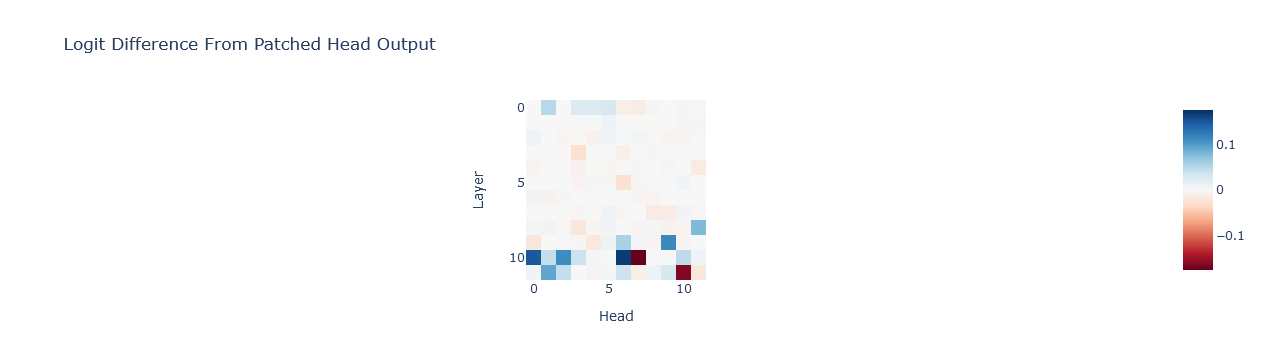

In [ ]:
imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
)

Following the logic of the tutorial and looking at this graph, we know layers 0, 9, and 10 are very important for gathering the info and moving it around. It seems to me that L0H1 and L0H3-5 are grabbing the name info and storing it on the surname, while heads L8H11, L9H6, L9H9, L10H0, L10H2, L10H6, and L10H7 are responsible for moving it to the final token ("."). Interestingly, it seems like L10 has many heads that improve performance and one head that significantly decreases it. This is unlike the IOI task, where it seems that the increase/decrease of performance was similar per-layer.

It looks like the early layers per-head contribution is somewhat scattered and that most of the computation is happening later in the chain.

In [ ]:
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("v", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_v_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

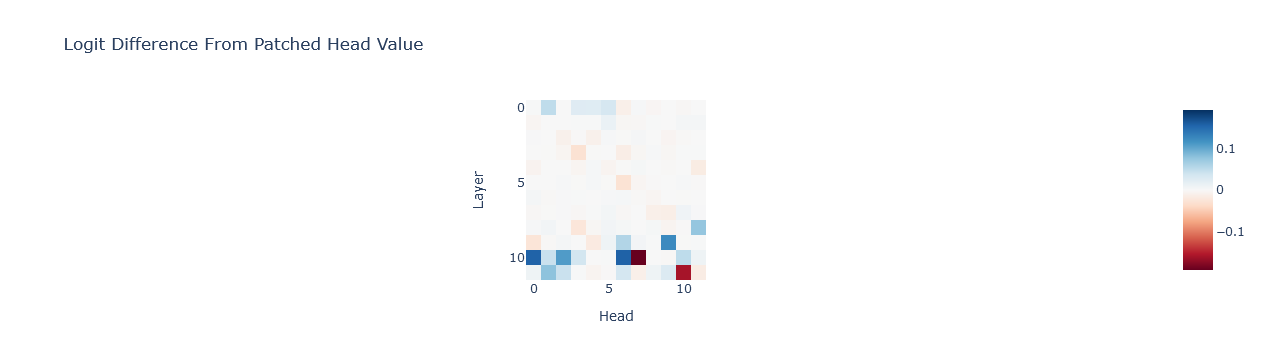

In [ ]:
imshow(
    patched_head_v_diff,
    title="Logit Difference From Patched Head Value",
    labels={"x": "Head", "y": "Layer"},
)

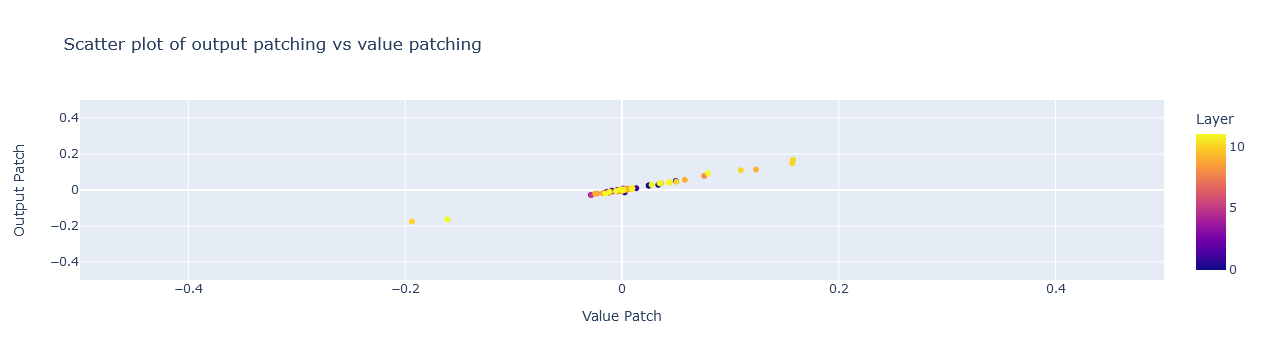

In [ ]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

In [ ]:
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][
        :, head_index, :, :
    ]
    return corrupted_head_pattern


patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

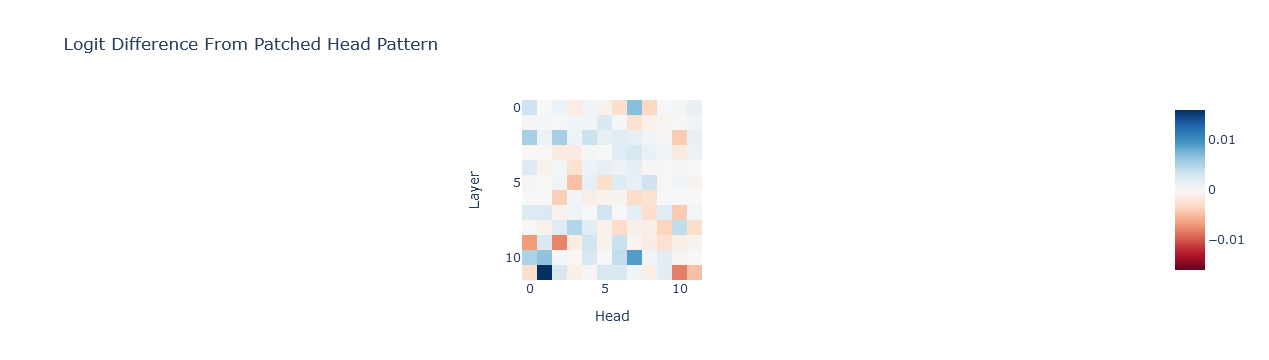

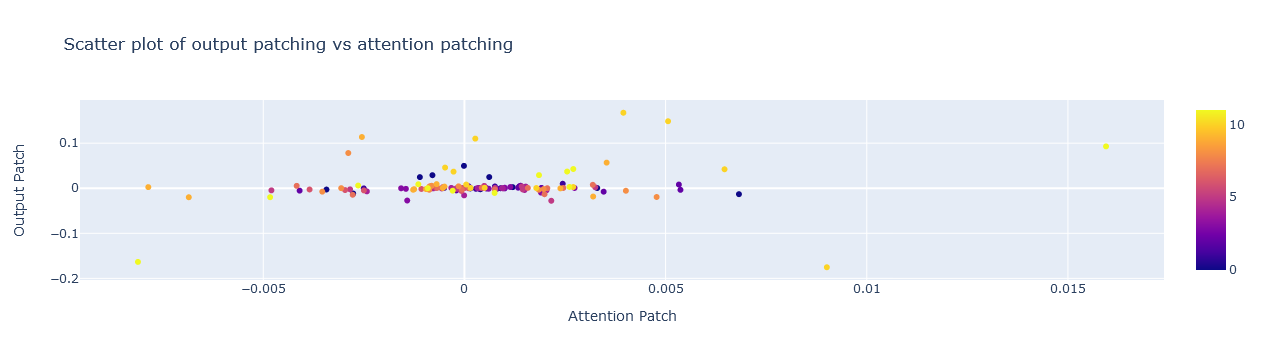

In [ ]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)

Now this is different! Looking at the scale of the graph for the relative output patching vs attention patching, it seems like attention patching is having little to no impact on the model at all! It seems as though most of the attention contributions are happening through the value circuit.

This makes sense with how the attention behavior is described in the IOI circuit as well - the attention patching was very impactful on middle layers in the model and less impactful for early and late layers for that task. However, we were seeing here initially that the middle layers did not have much of an impact as a whole when patching the layer, so it makes sense that attention key/query patching doesn't make much of a difference.

My intuition is telling me that the most likely mechanism for this task is an immediate pairing of names in the first layer of the model, which the last layers of the model use to fetch only the surname. Let's see if we can test this.

In [ ]:
top_k = 100
top_heads_by_output_patch = torch.topk(
    patched_head_z_diff.abs().flatten(), k=top_k
).indices
first_mid_layer = 7
first_late_layer = 9
early_heads = top_heads_by_output_patch[
    top_heads_by_output_patch < model.cfg.n_heads * first_mid_layer
]
mid_heads = top_heads_by_output_patch[
    torch.logical_and(
        model.cfg.n_heads * first_mid_layer <= top_heads_by_output_patch,
        top_heads_by_output_patch < model.cfg.n_heads * first_late_layer,
    )
]
late_heads = top_heads_by_output_patch[
    model.cfg.n_heads * first_late_layer <= top_heads_by_output_patch
]

early = visualize_attention_patterns(
    early_heads, cache, tokens[0], title=f"Top Early Heads"
)
mid = visualize_attention_patterns(
    mid_heads, cache, tokens[0], title=f"Top Middle Heads"
)
late = visualize_attention_patterns(
    late_heads, cache, tokens[0], title=f"Top Late Heads"
)

HTML(early + mid + late)

Let's try a different corruption mechanism

## Another Corruption Mechanism

In [ ]:
name_replacement = {
    "Mark": "George",
    "Grant": "Keith",
    "Paul": "Nick",
    "Allen": "Jake",
    "John": "Jacob",
    "Larry": "Jordan",
    "James": "David",
    "Andy": "Blake",
    "Elizabeth": "Rose",
    "Taylor": "Kate",
    "Emily": "Jane",
    "Anne": "Jean",
    "Grey": "May",
    "Ann": "Ben"
}

corrupted_prompts = []
for i in range(0, len(prompts)):
    surname = prompts[i].split(' ')[1]
    corrupted_prompts.append(prompts[i].replace(surname, name_replacement[surname]))
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(
    corrupted_tokens, return_type="logits"
)
corrupted_average_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(original_average_logit_diff.item(), 2))

Corrupted Average Logit Diff -2.76
Clean Average Logit Diff 2.12


In [ ]:
model.to_string(corrupted_tokens)

['<|endoftext|>Grant George usually goes by Mr.',
 '<|endoftext|>Mark Keith usually goes by Mr.',
 '<|endoftext|>Allen Nick usually goes by Mr.',
 '<|endoftext|>Paul Jake usually goes by Mr.',
 '<|endoftext|>Larry Jacob usually goes by Mr.',
 '<|endoftext|>John Jordan usually goes by Mr.',
 '<|endoftext|>Andy David usually goes by Mr.',
 '<|endoftext|>James Blake usually goes by Mr.',
 '<|endoftext|>Taylor Rose usually goes by Mr.',
 '<|endoftext|>Elizabeth Kate usually goes by Mr.',
 '<|endoftext|>Anne Jane usually goes by Mr.',
 '<|endoftext|>Emily Jean usually goes by Mr.',
 '<|endoftext|>Ann May usually goes by Mr.',
 '<|endoftext|>Grey Ben usually goes by Mr.',
 '<|endoftext|>Grant George usually goes by Ms.',
 '<|endoftext|>Mark Keith usually goes by Ms.',
 '<|endoftext|>Allen Nick usually goes by Ms.',
 '<|endoftext|>Paul Jake usually goes by Ms.',
 '<|endoftext|>Larry Jacob usually goes by Ms.',
 '<|endoftext|>John Jordan usually goes by Ms.',
 '<|endoftext|>Andy David usually 

In [ ]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff) / (
        original_average_logit_diff - corrupted_average_logit_diff
    )


patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
            patched_logit_diff
        )

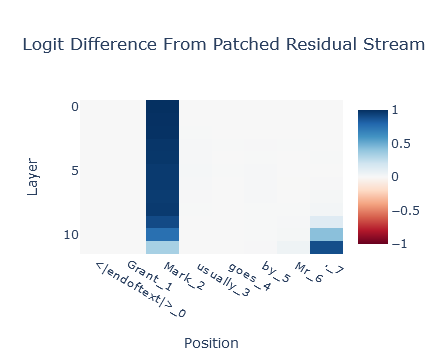

In [ ]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

In [ ]:
patched_attn_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    model.cfg.n_layers, tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(
            patched_attn_logits, answer_tokens
        )
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_mlp_logit_diff = logits_to_ave_logit_diff(
            patched_mlp_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(
            patched_attn_logit_diff
        )
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(
            patched_mlp_logit_diff
        )

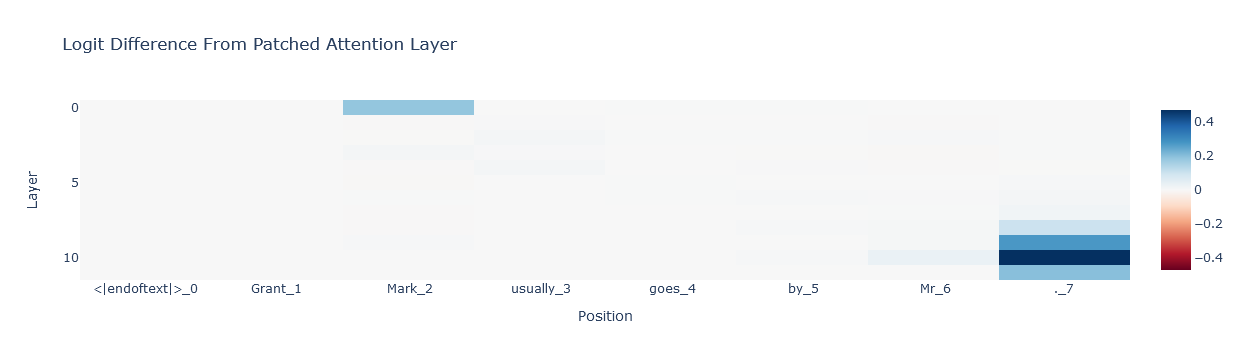

In [ ]:
imshow(
    patched_attn_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention Layer",
    labels={"x": "Position", "y": "Layer"},
)

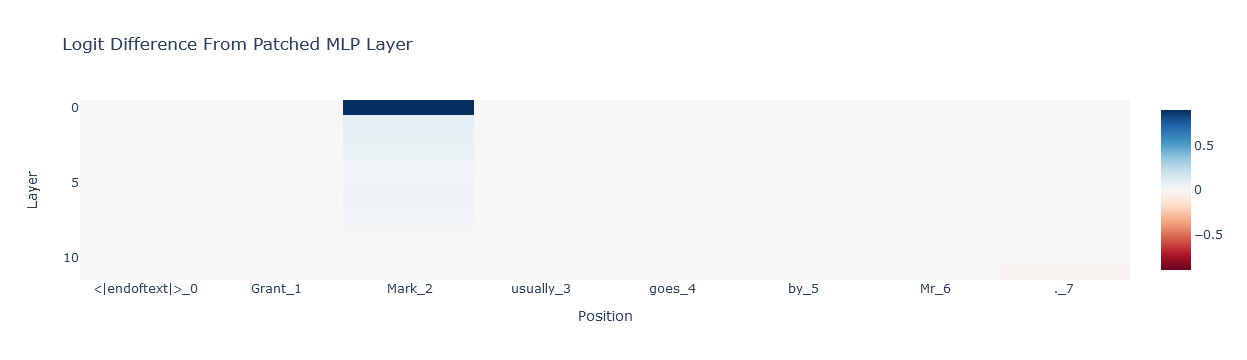

In [ ]:
imshow(
    patched_mlp_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched MLP Layer",
    labels={"x": "Position", "y": "Layer"},
)

In [ ]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

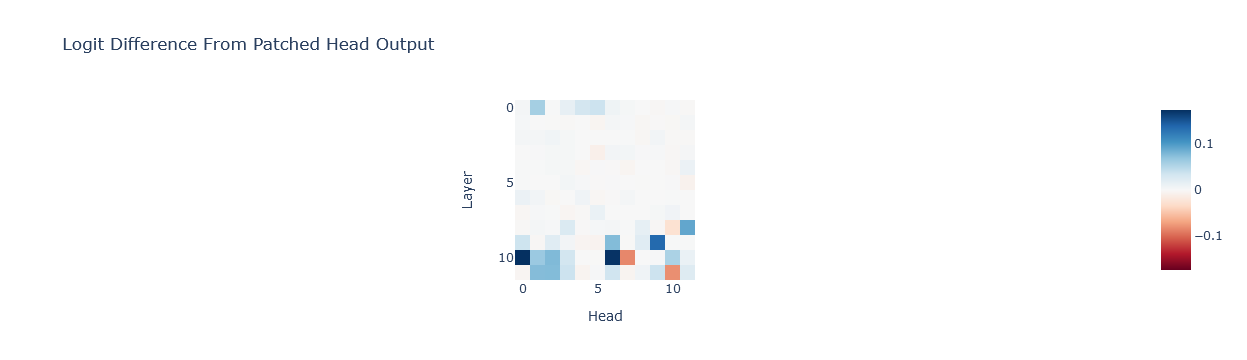

In [ ]:
imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
)

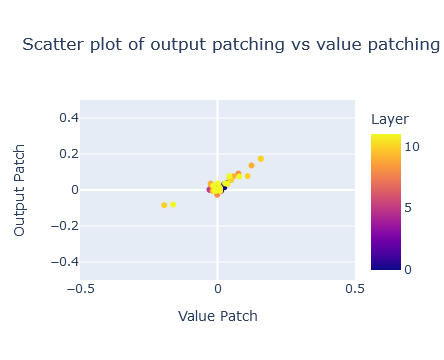

In [ ]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

In [ ]:
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][
        :, head_index, :, :
    ]
    return corrupted_head_pattern


patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

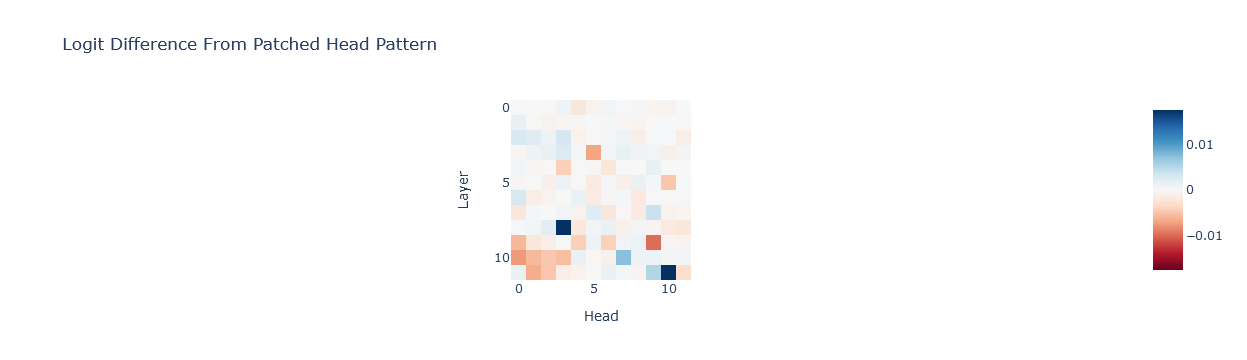

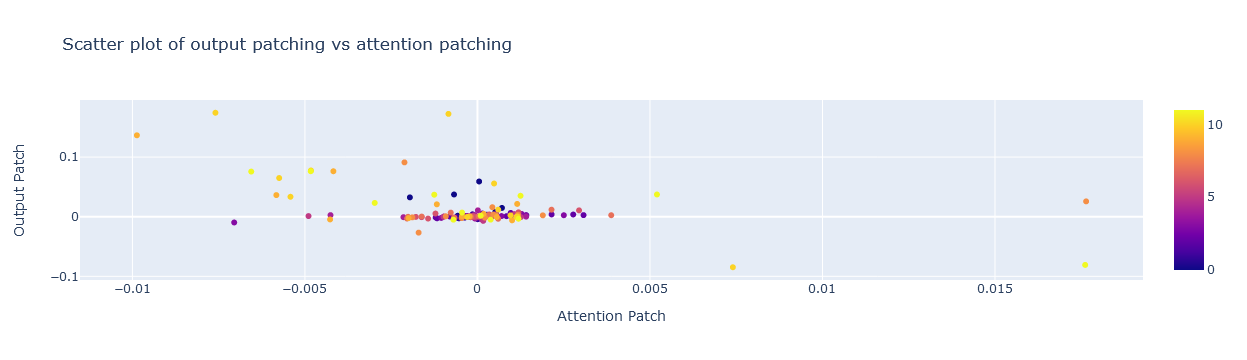

In [ ]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)

In [ ]:
early_heads

tensor([], device='cuda:0', dtype=torch.int64)

In [ ]:
top_k = 15
top_heads_by_output_patch = torch.topk(
    patched_head_z_diff.abs().flatten(), k=top_k
).indices
first_mid_layer = 7
first_late_layer = 9
early_heads = top_heads_by_output_patch[
    top_heads_by_output_patch < model.cfg.n_heads * first_mid_layer
]
mid_heads = top_heads_by_output_patch[
    torch.logical_and(
        model.cfg.n_heads * first_mid_layer <= top_heads_by_output_patch,
        top_heads_by_output_patch < model.cfg.n_heads * first_late_layer,
    )
]
late_heads = top_heads_by_output_patch[
    model.cfg.n_heads * first_late_layer <= top_heads_by_output_patch
]

early, mid, late = None, None, None

if len(early_heads):
    early = visualize_attention_patterns(
        early_heads, cache, tokens[0], title=f"Top Early Heads"
    )

if len(mid_heads):
    mid = visualize_attention_patterns(
        mid_heads, cache, tokens[0], title=f"Top Middle Heads"
    )

if len(late_heads):
    late = visualize_attention_patterns(
        late_heads, cache, tokens[0], title=f"Top Late Heads"
    )

HTML(early + mid + late)